In [1]:
import os
os.chdir('..')
from notebooks import config
import numpy as np
import torch
import time
import random
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from model.seg_model.unet import unet
from dataloader.read_normalize import read_normalize
from dataloader.parallel_loader import threads_scene_dset
from dataloader.loader import patch_tensor_dset
from utils.imgShow import imgShow, imsShow
from model.seg_model.helper import convert_g_l


In [2]:
'''--------- data loading --------'''
### ----- val data loading: from prepared validation patches ------ ###
patch_list_val = [torch.load(path) for path in config.paths_patch_val]
val_dset = patch_tensor_dset(patch_pair_list = patch_list_val)
### ------- print ------- ###
print('size of val data:', val_dset.__len__())


size of val data: 250


In [136]:
class bandjitter:
    '''numpy-based
       des: randomly bandjitter with given probability, 
       color jitter contains bright adjust and contrast adjust.
       '''
    def __init__(self, prob=0.5):
        self.p = prob
    def __call__(self, patches, truth):
        '''image, truth: torch.Tensor'''
        if random.random() > self.p:
            return patches, truth  
        if isinstance(patches, list):
            num_band = patches[0].shape[0]
        else: 
            num_band = patches.shape[0]
        order = np.arange(num_band)
        random.shuffle(order)
        if isinstance(patches, list):
            patches_aug = [patch[order] for patch in patches]
        else: 
            patches_aug = patches[order]
        return patches_aug, truth


0.054303884506225586


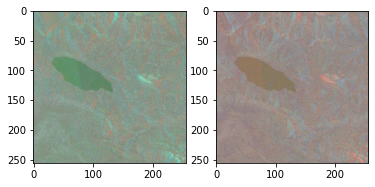

In [137]:
input_array, truth_array = val_dset[0][0][0].detach().numpy(), val_dset[0][0][1].detach().numpy()
input_array = [input_array,input_array,input_array]

start = time.time()
input_array_aug, truth_array = bandjitter(1)(input_array,truth_array)
print(time.time()-start)
plt.subplot(1,2,1)
imgShow(input_array[0].transpose(1,2,0),clip_percent=0)
plt.subplot(1,2,2)
imgShow(input_array_aug[0].transpose(1,2,0), clip_percent=0, color_bands=[2,1,0])

# start = time.time()
# for i in range(100):
#     input_array_aug, truth_array = bandjitter(1)(input_array,truth_array)
# print(time.time()-start)


In [ ]:
val_loader = torch.utils.data.DataLoader(val_dset, batch_size=16)

In [ ]:
# model_name= 'unet_vary'
# model_weights = config.root + '/model/pretrained/'+model_name+'_weights.pth'
# model = unet(num_bands=4, num_classes=2)
# model.load_state_dict(torch.load(model_weights))
# model=model.eval()



In [ ]:
# for i in range(20):
#     ## --- select image
#     sam_index = random.randrange(len(val_dset))
#     patches, truth = val_dset[sam_index]
#     patches = [torch.unsqueeze(patch, 0) for patch in patches]
#     ## prediction on high-scale
#     pred_high = model(patches[0])
#     pred_high2low = convert_g_l(img_g=pred_high, scale_ratio=8).detach().numpy()
#     ## prediction on mid-scale
#     pred_mid = model(patches[1])
#     pred_mid2low = convert_g_l(img_g=pred_mid, scale_ratio=2).detach().numpy()
#     ## prediction on low-scale
#     pred_low = model(patches[2])
#     patches = [patch[0].detach().numpy().transpose(1,2,0) for patch in patches]
#     pred_high, pred_mid, pred_low = pred_high.detach().numpy(),pred_mid.detach().numpy(),pred_low.detach().numpy()
#     truth = truth.detach().numpy()
#     # --- plot
#     plt.figure(figsize=(10,6))
#     patches_list = patches + [truth] + [pred_high, pred_mid, pred_high2low, pred_mid2low, pred_low]
#     patches_name = ['input_high','input_mid','input_low','truth', 'pred_high', \
#                                             'pred_mid','pred_high2low','pred_mid2low','pred_low']
#     clip_list = [2,2,2,0,0,0,0,0,0]
#     col_bands_list = [(2,1,0), (2,1,0), (2,1,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0)]
#     imsShow(img_list=patches_list, img_name_list=patches_name, \
#                                 clip_list=clip_list, color_bands_list=col_bands_list, row=2, col=5)
#     plt.show()
